In [270]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
from scipy.integrate import quad
from IPython.display import HTML
import pandas as pd
from matplotlib import cm

In [271]:
%%HTML
<button onclick="$('.input, .prompt, .output_stderr, .output_error, .output_result').toggle();">Toggle Code</button>

## BSM model

In [272]:
def dN(x):
    return math.exp(-0.5*x**2)/math.sqrt(2*math.pi)

def N(d):
    return quad(lambda x:dN(x),-20,d,limit=50)[0]

def d1f(St, K, t, T, r, sigma):
    d1 = (math.log(St / K) + (r + 0.5 * sigma ** 2) * (T - t)) / (sigma * math.sqrt(T - t))
    return d1

def BSM_call_value(St, K, t, T, r, sigma):
    d1=d1f(St,K,t,T,r,sigma)
    d2=d1-sigma*math.sqrt(T-t)
    call_value = St * N(d1) - math.exp(-r * (T - t)) * K * N(d2)
    return call_value

def BSM_put_value(St, K, t, T, r, sigma):
    put_value = BSM_call_value(St,K,t,T,r,sigma)-St + math.exp(-r * (T - t)) * K
    return put_value

## Greeks

In [331]:
table = """<table><tr><th>Greek</th><th>Call<pre>                           </pre></th><th>Put<pre>                           </pre></th></tr><tr><td>Delta $\Delta$</td><td>$N(d_1)$</td><td>$-N(-d_1)$</td></tr><tr><td>Theta $\Theta$</td><td>$\\frac{-\sigma SN'(d_1)}{2\sqrt{T-t}} - rKe^{-r(T-t)} N(d_2)$</td><td>$\\frac{-\sigma SN'(d_1)}{2\sqrt{T-t}} + rKe^{-r(T-t)} N(d_2)$</td></tr><tr><td>Gamma $\Gamma$</td><td>$\\frac{N'(d_1)}{S\sigma \sqrt{T}}$</td><td>$\\frac{N'(d_1)}{S\sigma \sqrt{T}}$</td></tr><tr><td>Vega $v$</td><td>$S_0 N'(d_1)\sqrt{T}$</td><td>$S_0 N'(d_1)\sqrt{T}$</td></tr><tr><td>Rho $\\rho$</td><td>$TKe^{-r(T)} N(d_2)$</td><td>$-TKe^{-r(T)} N(-d_2)$</td></tr></table>"""
HTML(table)

Greek,Call,Put
Delta $\Delta$,$N(d_1)$,$-N(-d_1)$
Theta $\Theta$,$\frac{-\sigma SN'(d_1)}{2\sqrt{T-t}} - rKe^{-r(T-t)} N(d_2)$,$\frac{-\sigma SN'(d_1)}{2\sqrt{T-t}} + rKe^{-r(T-t)} N(d_2)$
Gamma $\Gamma$,$\frac{N'(d_1)}{S\sigma \sqrt{T}}$,$\frac{N'(d_1)}{S\sigma \sqrt{T}}$
Vega $v$,$S_0 N'(d_1)\sqrt{T}$,$S_0 N'(d_1)\sqrt{T}$
Rho $\rho$,$TKe^{-r(T)} N(d_2)$,$-TKe^{-r(T)} N(-d_2)$


In [274]:
def BSM_delta (St, K, t, T, r, sigma):
    d1=d1f(St, K, t, T, r, sigma)
    delta=N(d1)
    return delta

def BSM_gamma(St, K, t, T, r, sigma):
    d1=d1f(St, K, t, T, r, sigma)
    gamma=dN(d1) / (St * sigma*math.sqrt(T-t))
    return gamma

def BSM_theta(St, K, t, T, r,sigma): #轉成正值
    d1 = d1f(St, K, t, T, r, sigma)
    d2 = d1 - sigma * math.sqrt(T - t)
    theta = -(St * dN(d1) * sigma / (2 * math.sqrt(T - t))
              + r * K * math.exp(-r * (T - t)) * N(d2))
    return -theta

def BSM_rho(St, K, t, T, r, sigma):
    d1 = d1f(St, K, t, T, r, sigma)
    d2 = d1 - sigma * math.sqrt(T - t)
    rho = K * (T - t) * math.exp(-r * (T - t)) * N(d2)
    return rho

def BSM_vega(St, K, t, T, r, sigma):
    d1 = d1f(St, K, t, T, r, sigma)
    vega = St * dN(d1) * math.sqrt(T - t)
    return vega

def BSM_vanna(St, K, t, T, r, sigma):
    d1 = d1f(St, K, t, T, r, sigma)
    d2 = d1 - sigma * math.sqrt(T - t)
    return dN(d1) * (-d2) / sigma

In [434]:
def plot_greeks(function, greek, tar="ST", ran=0.3, K=100, S=100, T=True):

    # model parameters
    St_ = S  # index level
    K_ = K  # option strike
    t_ = 0  # valuation date
    T_ = 1.0  # maturity date
    r_ = 0.05  # risk-less short rate
    sigma_ = 0.5  # volatility
    # Greek Calculations
    tlist = (np.linspace(0.01, 1, 100) if isinstance(T, bool) else np.linspace(T[0], T[-1], 100)) if "T" in tar else np.ones(100) * 0.1
    slist = np.linspace(1 - ran, 1 + ran, 100) * St_ if "S" in tar else np.ones(100) * St_
    klist = np.linspace(1 - ran, 1 + ran, 100) * K_
    sigmalist = np.linspace(1 - ran, 1 + ran, 100) * sigma_ if "V" in tar else np.ones(100) * sigma_
    V = np.zeros((len(tlist), len(slist)), dtype=np.float)
    for j in range(len(slist)):
        for i in range(len(tlist)):
            V[i, j] = function(slist[j], K_, t_, tlist[i], r_, sigmalist[i])

    # 3D Plotting
    x, y = np.meshgrid(slist, tlist if "T" in tar else sigmalist)
    fig = plt.figure(figsize=(9, 6))
    plot = Axes3D(fig)
    plot.plot_surface(x, y, V, cmap=plt.get_cmap('bone'))
    plot.set_xlabel('stock $S$')
    plot.set_ylabel('maturity $T$' if "T" in tar else 'vol $\sigma$')
    plot.set_zlabel('%s' % greek)
    plot.set_title('$\%s$' %greek) if greek in ["Delta", "Gamma", "Theta"]else plot.set_title('$%s$' %greek)

In [447]:
def plot_greeks_2nd(function, greek, tar="V", K=[90, 100, 107], S=100, ran=0.4, T=True):

    # model parameters
    St_ = S  # index level
    K_ = K  # option strike
    t_ = 0  # valuation date
    T_ = 1.0  # maturity date
    r_ = 0.05  # risk-less short rate
    sigma_ = 0.5  # volatility
    # Greek Calculations
    tlist = np.linspace(0.01, ran, 100) if "T" in tar else np.ones(100) * 0.1
    slist = np.ones(100) * St_
    sigmalist = np.linspace(0.4, 1 + ran, 100) * sigma_ if "V" in tar else np.ones(100) * sigma_
    V = np.zeros((3, 100), dtype=np.float)
    for i in range(100):
        for j in range(3):        
            V[j, i] = function(St_, K_[j], t_, tlist[i], r_, sigmalist[i])
    M = pd.DataFrame(np.transpose(V), index=sigmalist if "V" in tar else tlist, columns=["ITM", "ATM", "OTM"])
    M.index.name = "vol" if "V" in tar else "T"
    return M

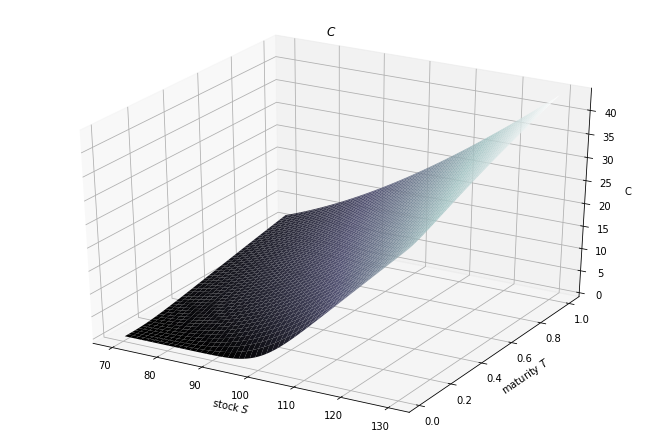

In [374]:
plot_greeks(BSM_call_value, "C")

# Greek w.r.t  ($\sigma$, $T$ )

## Delta $\Delta$
##### $\sigma$ 變大 價內會變小 價外會變大

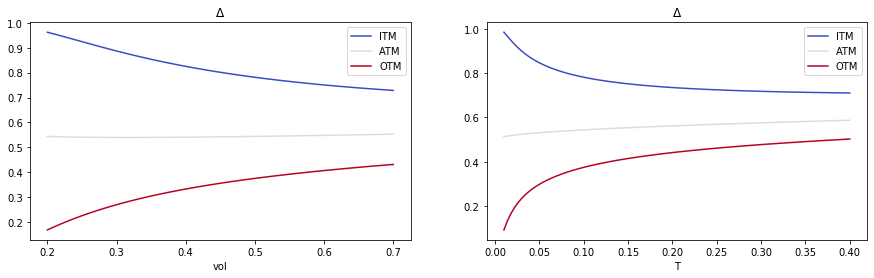

In [448]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figwidth(15)
plot_greeks_2nd(BSM_delta, "$\Delta$").plot(title = "$\Delta$", colormap="coolwarm", ax=axes[0])
plot_greeks_2nd(BSM_delta, "$\Delta$", tar="T").plot(title = "$\Delta$", colormap="coolwarm", ax=axes[1])
plt.show()

##### T

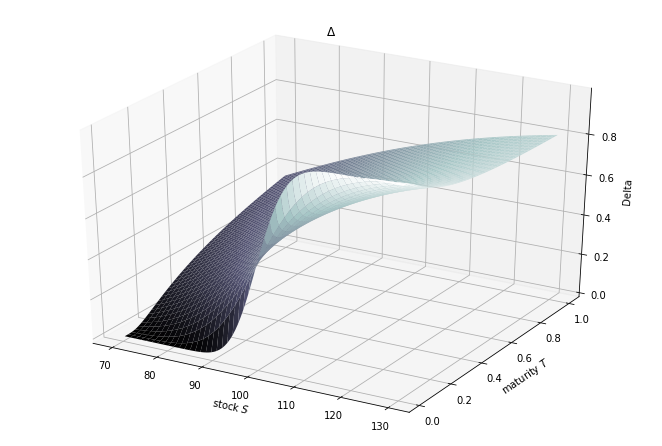

In [369]:
plot_greeks(BSM_delta,"Delta")

###### $\sigma$

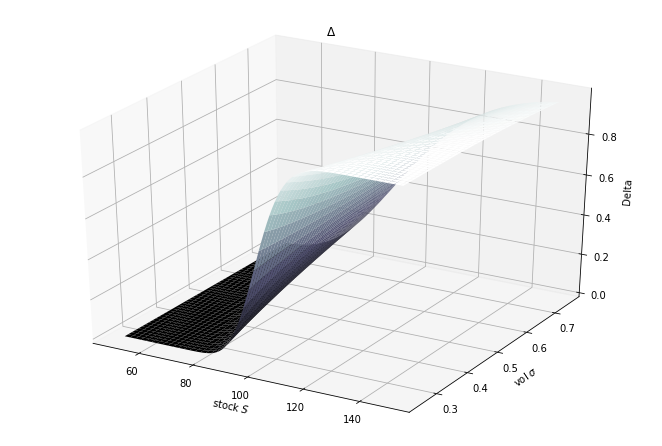

In [376]:
plot_greeks(BSM_delta,"Delta", "SV", ran=0.5)

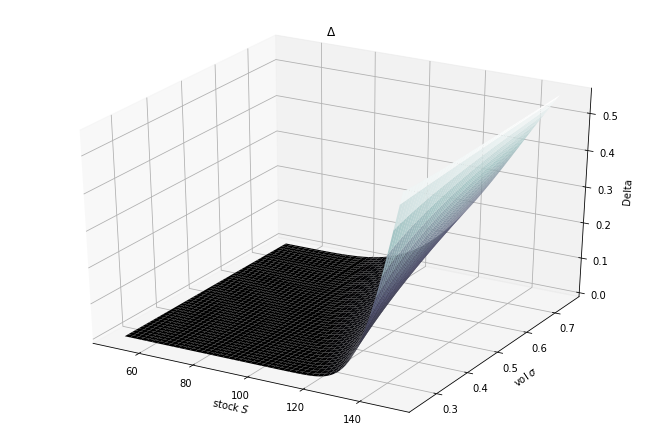

In [377]:
plot_greeks(BSM_delta,"Delta", "SV", ran=0.5, K=150)#價外

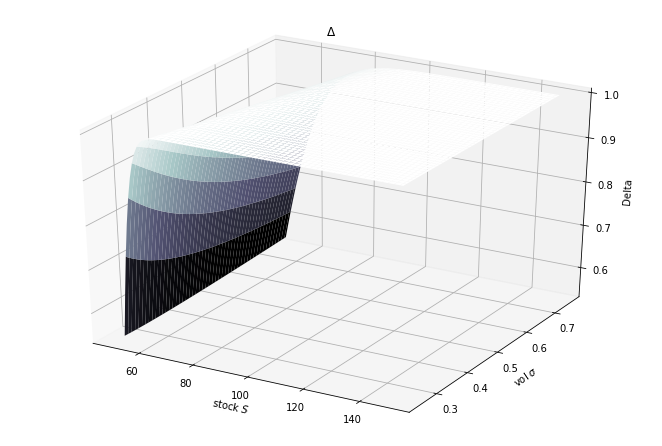

In [378]:
plot_greeks(BSM_delta,"Delta", "SV", ran=0.5, K=50)#價內

## Gamma $\Gamma$
##### $\sigma$ 變大 價內價外都變小

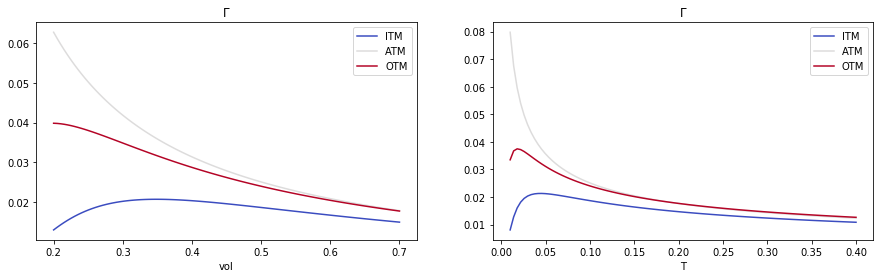

In [452]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figwidth(15)
plot_greeks_2nd(BSM_gamma, "$\Gamma$").plot(title = "$\Gamma$", colormap="coolwarm", ax=axes[0])
plot_greeks_2nd(BSM_gamma, "$\Gamma$", tar="T").plot(title = "$\Gamma$", colormap="coolwarm", ax=axes[1])
plt.show()

##### T

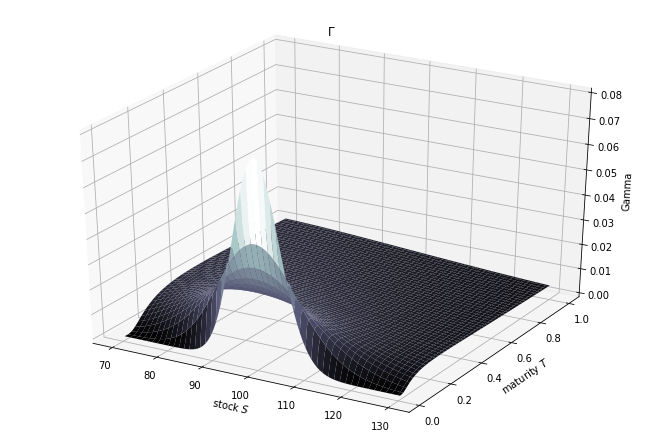

In [370]:
plot_greeks(BSM_gamma,"Gamma")

###### $\sigma$

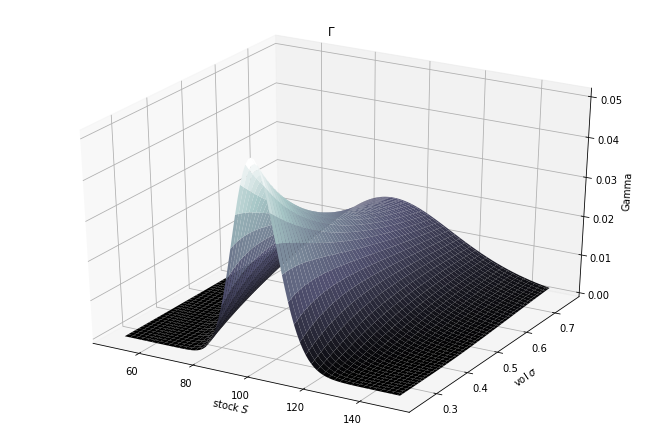

In [380]:
plot_greeks(BSM_gamma,"Gamma", "SV", ran=0.5)

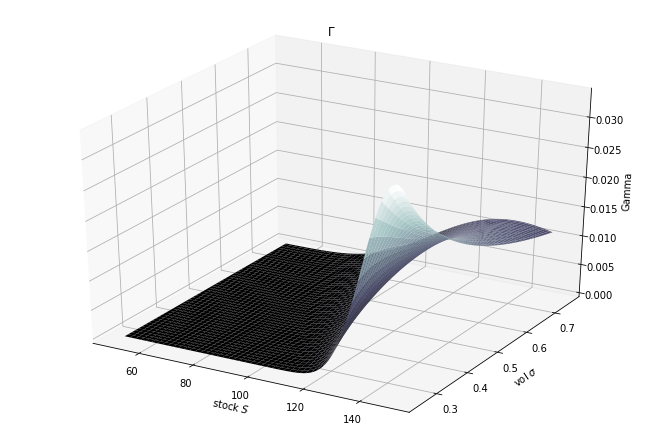

In [381]:
plot_greeks(BSM_gamma,"Gamma", "SV", ran=0.5, K=150)#價外

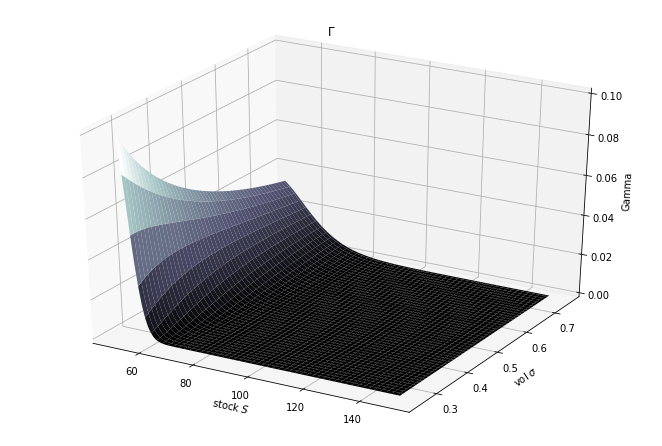

In [382]:
plot_greeks(BSM_gamma,"Gamma", "SV", ran=0.5, K=50)#價內

## Theta $\Theta$
##### $\sigma$ 變大 價內價外都變大(負更多)

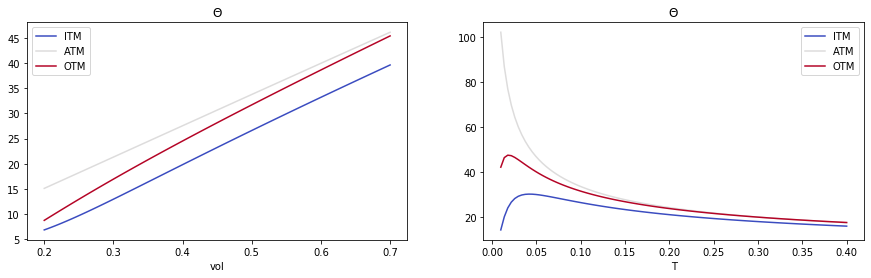

In [450]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figwidth(15)
plot_greeks_2nd(BSM_theta, "$\Theta$").plot(title = "$\Theta$", colormap="coolwarm", ax=axes[0])
plot_greeks_2nd(BSM_theta, "$\Theta$", tar="T").plot(title = "$\Theta$", colormap="coolwarm", ax=axes[1])
plt.show()

##### T

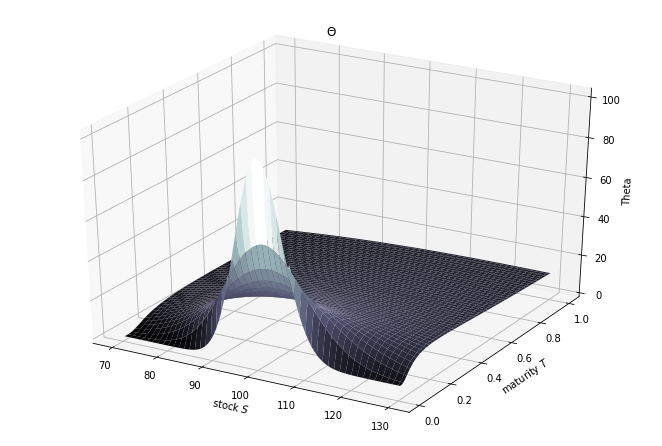

In [371]:
plot_greeks(BSM_theta,"Theta")

###### $\sigma$

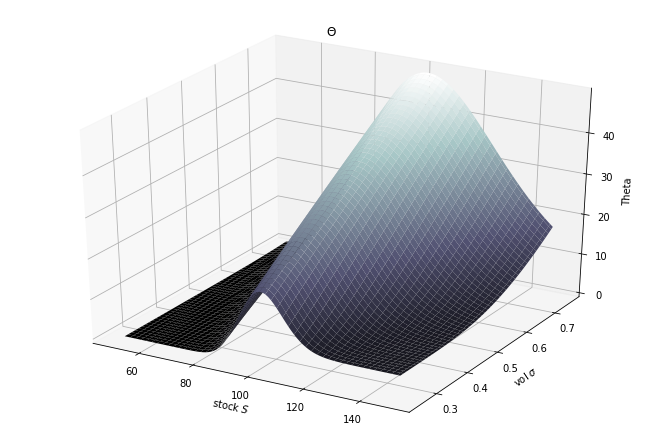

In [384]:
plot_greeks(BSM_theta,"Theta", "SV", ran=0.5)

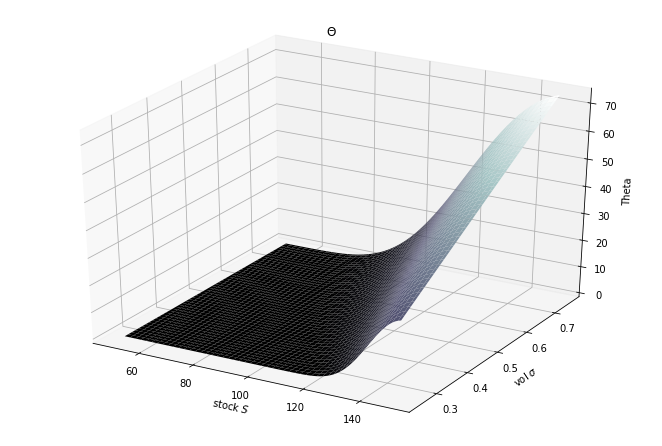

In [385]:
plot_greeks(BSM_theta,"Theta", "SV", ran=0.5, K=150)#價外

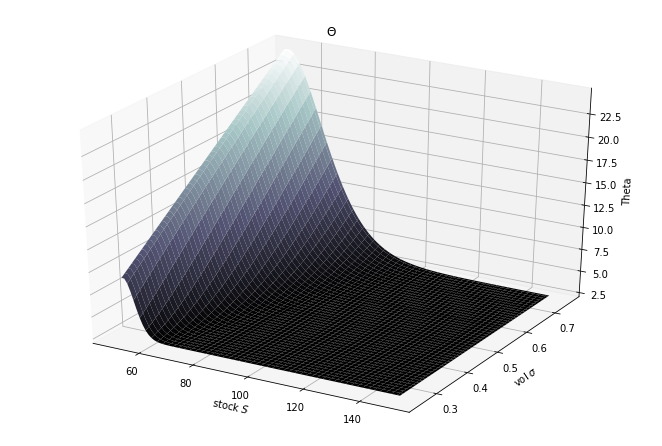

In [386]:
plot_greeks(BSM_theta,"Theta", "SV", ran=0.5, K=50)#價內

## Vega $v$
##### $v$ 變大 價內價外都變大 
https://brilliant.org/wiki/option-greeks-vega/

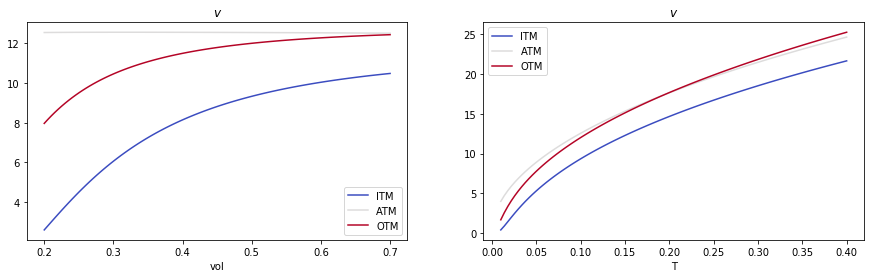

In [451]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figwidth(15)
plot_greeks_2nd(BSM_vega, "$v$").plot(title = "$v$", colormap="coolwarm", ax=axes[0])
plot_greeks_2nd(BSM_vega, "$v$", tar="T").plot(title = "$v$", colormap="coolwarm", ax=axes[1])
plt.show()

##### T

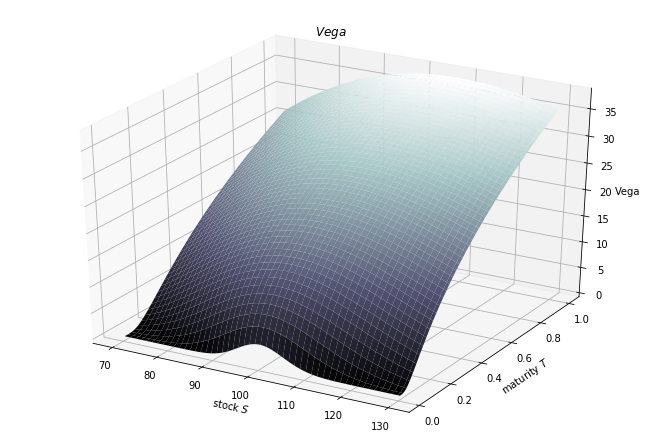

In [372]:
plot_greeks(BSM_vega,"Vega")

###### $\sigma$

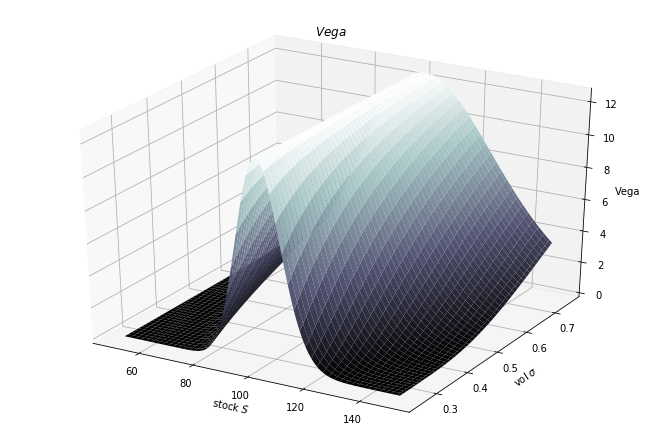

In [388]:
plot_greeks(BSM_vega,"Vega", "SV", ran=0.5)

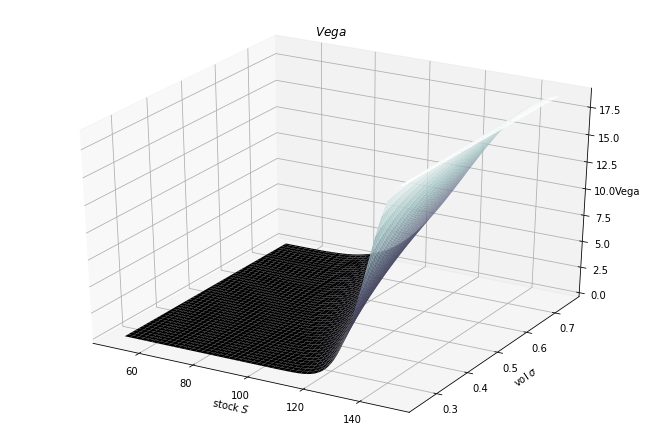

In [389]:
plot_greeks(BSM_vega,"Vega", "SV", ran=0.5, K=150)#價外

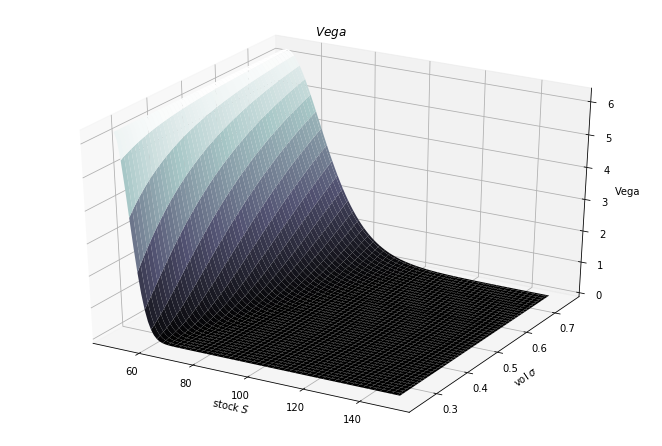

In [390]:
plot_greeks(BSM_vega,"Vega", "SV", ran=0.5, K=50)#價內

## Vanna

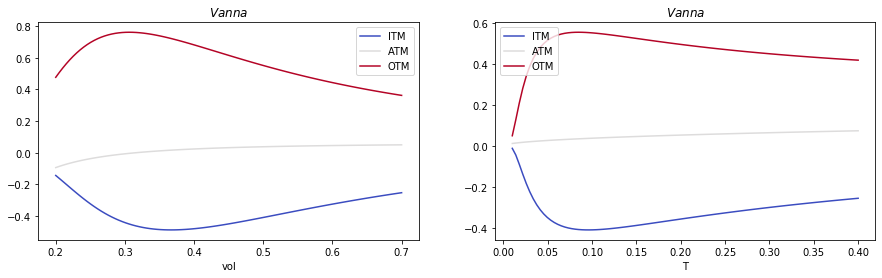

In [421]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figwidth(15)
plot_greeks_2nd(BSM_vanna, "$vanna$").plot(title = "$Vanna$", colormap="coolwarm", ax=axes[0])
plot_greeks_2nd(BSM_vanna, "$vanna$", tar="T").plot(title = "$Vanna$", colormap="coolwarm", ax=axes[1])
plt.show()

##### T

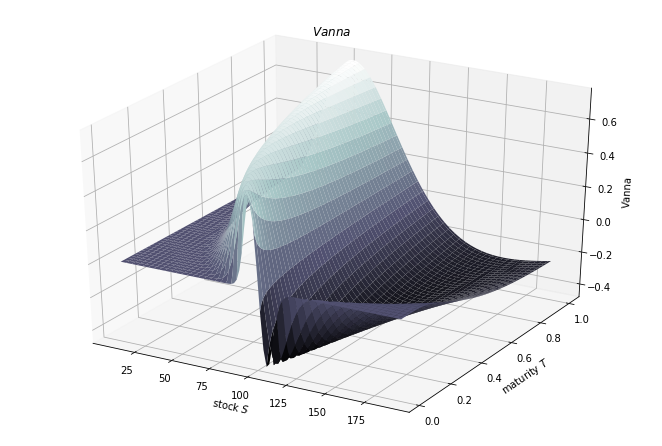

In [373]:
plot_greeks(BSM_vanna,"Vanna", ran=0.9)

###### $\sigma$

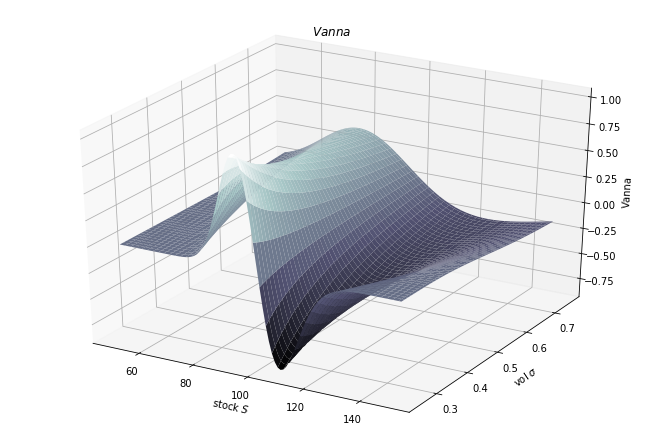

In [392]:
plot_greeks(BSM_vanna,"Vanna", "SV", ran=0.5)

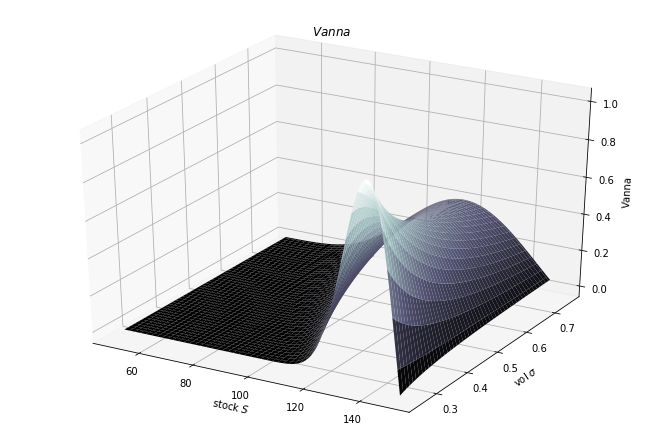

In [393]:
plot_greeks(BSM_vanna,"Vanna", "SV", ran=0.5, K=150)#價外

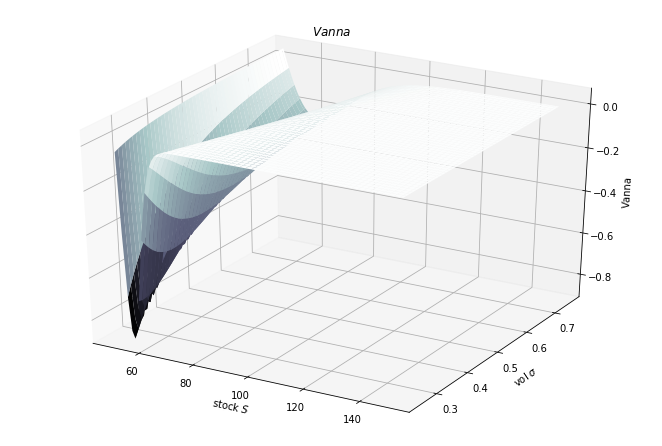

In [394]:
plot_greeks(BSM_vanna,"Vanna", "SV", ran=0.5, K=50)#價內

In [303]:
A = lambda n : np.diag(np.ones(n-1), -1) + np.diag(np.ones(n) * 2, 0) + np.diag(np.ones(n-1), 1)

In [240]:
S = lambda n : {"inv" : np.linalg.inv(A(n)), "det" : np.linalg.det(A(n)), "mul" : np.linalg.inv(A(n)) * np.linalg.det(A(n))}

In [ ]:
S(4)

In [ ]:
S(5)

In [ ]:
S(6)

In [ ]:
S(10)